Import tools and define files

In [2]:
import argparse
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
from pygmlparser.Parser import Parser as GmlParser

EDGELIST = 'umdEdges.csv'
NODELIST = 'umdPOI.csv'
OUTPUT_CSV = 'short_graph.csv'
OUTPUT_GML = 'short_graph.gml'
OUTPUT_KML = 'short_graph.kml'

In [3]:
def create_complete_graph(pair_weights, flip_weights=True):
    '''create a complete graph from the pair weights'''
    graph_complete = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = -v if flip_weights else v
        graph_complete.add_edge(k[0], k[1], weight=wt_i)
    return graph_complete

In [4]:
def get_shortest_paths_distance(graph_s, pairs, edge_weight_name='weight'):
    '''get the shortest path distances between all pairs of nodes'''
    distances = {}
    for pair_s in pairs:
        distances[pair_s] = nx.dijkstra_path_length(graph_s, pair_s[0], pair_s[1], weight=edge_weight_name)
    return distances

Load the edges and nodes from the csv files to the networkx graph

In [5]:
edgelist = pd.read_csv(EDGELIST)
nodelist = pd.read_csv(NODELIST)

graph=nx.Graph()
for _, elrow in edgelist.iterrows():
    graph.add_edge(elrow[0], elrow[1], weight = elrow[2])

for _, nlrow in nodelist.iterrows():
    graph.add_node(nlrow[0], attr_dict=nlrow[1:].to_dict())

node_positions = {}
for node in graph.nodes(data=True):
    node_positions[node[0]] = (node[1]['attr_dict']['longitude'],
                               node[1]['attr_dict']['latitude'])

In [6]:
nodes_odd_degree = [v for v, d in graph.degree() if d % 2 == 1]

In [7]:
odd_node_pairs = list(itertools.combinations(nodes_odd_degree, 2))

In [8]:
odd_node_pairs_shortest_paths = get_shortest_paths_distance(graph, odd_node_pairs, 'weight')

In [9]:
g_odd_complete = create_complete_graph(odd_node_pairs_shortest_paths, flip_weights=True)

<Figure size 1000x1000 with 0 Axes>

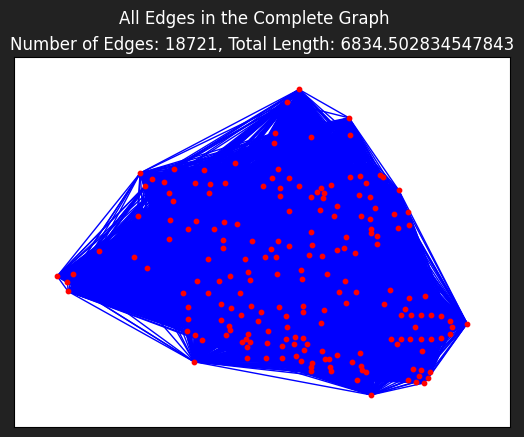

In [123]:
total_length = sum([v for _, v in odd_node_pairs_shortest_paths.items()])
plt.figure(figsize=(10, 10))
fig = plt.figure()
nx.draw_networkx(g_odd_complete, node_positions, node_size=10, node_color='r', edge_color='b', with_labels=False)
fig.set_facecolor("#222222")
plt.suptitle("All Edges in the Complete Graph", color='w')
plt.title(f"Number of Edges: {g_odd_complete.number_of_edges()}, Total Length: {total_length}", color='w')
plt.show()

In [10]:
odd_matching_dupes = nx.algorithms.max_weight_matching(g_odd_complete, True)
odd_matching = list(pd.unique([tuple(sorted([k,v])) for k, v in odd_matching_dupes]))

<Figure size 800x600 with 0 Axes>

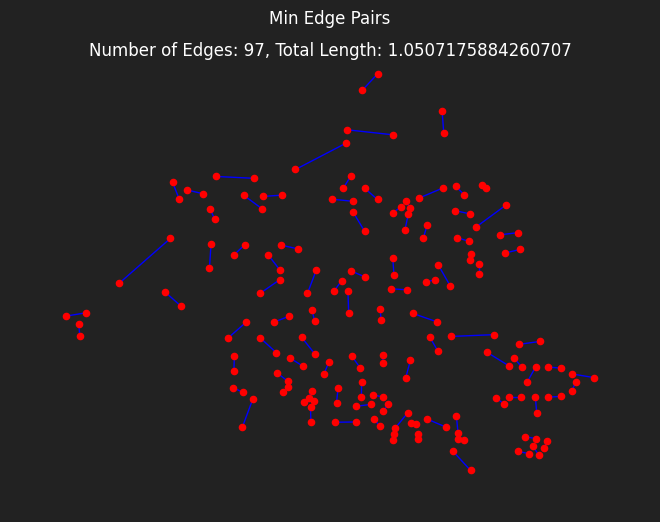

In [11]:
g_odd_complete_min_edges = nx.Graph(odd_matching_dupes)

min_pairs_total_length=0
for pair in g_odd_complete_min_edges.edges():
    if(pair[1],pair[0]) in odd_node_pairs_shortest_paths.keys():
        min_pairs_total_length+=odd_node_pairs_shortest_paths[(pair[1],pair[0])]
    #print((pair[1],pair[0]) in odd_node_pairs_shortest_paths.keys())

#min_pairs_total_length = sum(int(odd_node_pairs_shortest_paths[(pair[1], pair[0])]) for pair in g_odd_complete_min_edges.edges() if (pair[1], pair[0]) in odd_node_pairs_shortest_paths.keys())


plt.figure(figsize=(8,6))
fig = plt.figure()
nx.draw(g_odd_complete_min_edges, pos = node_positions, node_size=20, edge_color = 'b', node_color='r')
fig.set_facecolor("#222222")
plt.title("Min Edge Pairs", color='white')
plt.suptitle(f"Number of Edges: {len(odd_matching)}, Total Length: {min_pairs_total_length}", color='white')
plt.show()

<Figure size 800x600 with 0 Axes>

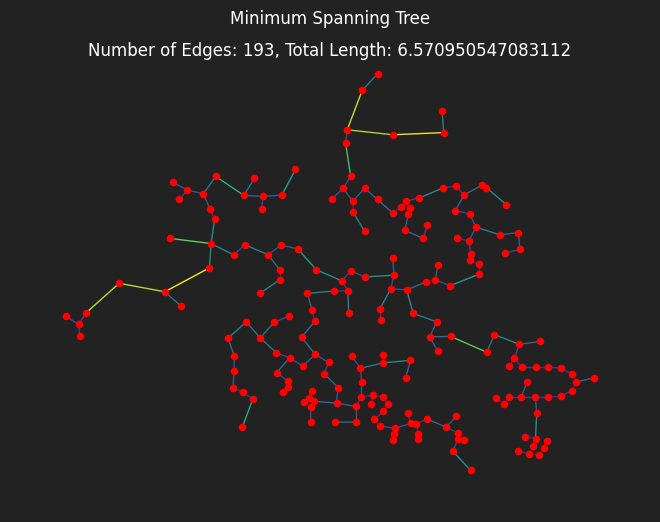

In [12]:
min_graph = nx.minimum_spanning_tree(graph)

min_graph_total_length = sum([d['weight'] for _, _, d in min_graph.edges(data=True)])

plt.figure(figsize=(8,6))
edge_colors = [min_graph[u][v]['weight'] for u,v in min_graph.edges()]
fig = plt.figure()
nx.draw(min_graph, pos = node_positions, node_size=20, edge_color=edge_colors,node_color='r')
fig.set_facecolor('#222222')
plt.title("Minimum Spanning Tree", color='white')
plt.suptitle(f"Number of Edges: {min_graph.number_of_edges()}, Total Length: {min_graph_total_length}", color='white')
plt.show()

<Figure size 800x600 with 0 Axes>

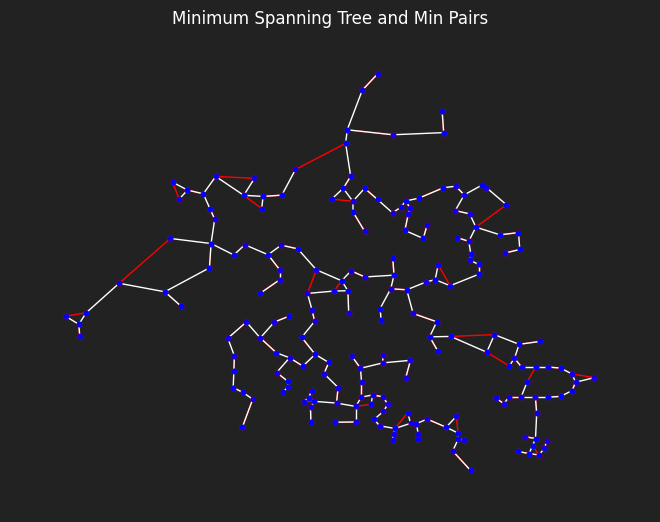

In [13]:
plt.figure(figsize=(8,6))
fig = plt.figure()
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=10, node_color='r', edge_color='r', with_labels=False)
nx.draw(min_graph, pos=node_positions, node_size=10, node_color='b', with_labels=False, edge_color='w')
fig.set_facecolor('#222222')
plt.title('Minimum Spanning Tree and Min Pairs', color='white')
plt.show()

<Figure size 800x600 with 0 Axes>

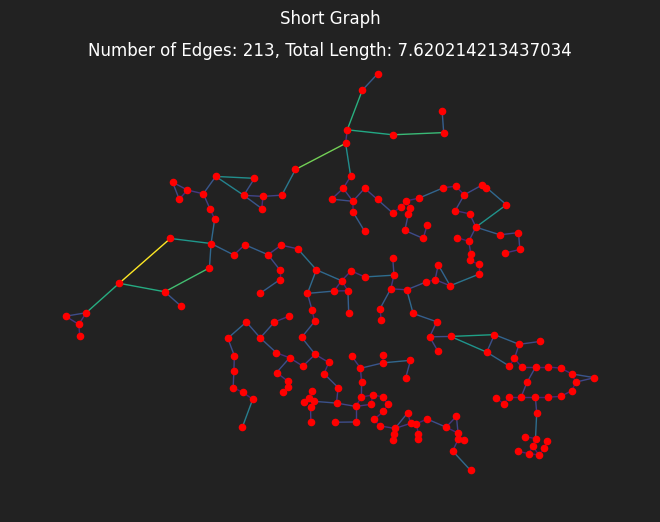

In [14]:
short_graph = nx.Graph()
for node in min_graph.nodes():
    short_graph.add_node(node, attr_dict=graph.nodes[node]['attr_dict'])
for edge in min_graph.edges():
    short_graph.add_edge(edge[0], edge[1], weight=graph.edges[edge]['weight'])
for edge in g_odd_complete_min_edges.edges():
    if (edge not in short_graph.edges()) & ((edge[1], edge[0]) not in short_graph.edges()):
        short_graph.add_edge(edge[0], edge[1], weight=graph.edges[edge]['weight'])

short_graph_total_length = sum([d['weight'] for _, _, d in short_graph.edges(data=True)])

plt.figure(figsize=(8,6))
edge_colors = [short_graph[u][v]['weight'] for u,v in short_graph.edges()]
fig = plt.figure()
nx.draw(short_graph, pos = node_positions, node_size=20, edge_color = edge_colors, node_color='r')
fig.set_facecolor("#222222")
plt.title("Short Graph", color='white')
plt.suptitle(f"Number of Edges: {short_graph.number_of_edges()}, Total Length: {short_graph_total_length}", color='white')
plt.show()

In [15]:
nx.write_gml(short_graph, OUTPUT_GML, repr)

Process the Edges and Notes from the GML file

In [16]:
with open(OUTPUT_GML, 'r', encoding='utf-8') as file:
    data = file.readlines()
short_nodes = []
short_edges = []
for i, line in enumerate(data):
    if data[i] == '  node [\n':
        id = int(data[i+1].strip().split(' ')[1])
        label = data[i+2].strip()[8:-2]
        long = float(data[i+4].strip().split(' ')[1])
        lat = float(data[i+5].strip().split(' ')[1])
        short_nodes.append((label, long, lat))

    if data[i] == '  edge [\n':
        source = short_nodes[int(data[i+1].strip().split(' ')[1])]
        target = short_nodes[int(data[i+2].strip().split(' ')[1])]
        short_edges.append((source, target))

Generate the text for a kml file

In [17]:
with open(OUTPUT_KML, 'w', encoding='utf-8') as file:
    file.write('''<?xml version=\"1.0\" encoding=\"UTF-8\"?>
    <kml xmlns=\"http://www.opengis.net/kml/2.2\">
    <Document>''')
    file.write('''
        <Style id=\"icon-blue-dot\">
            <LabelStyle>
                <scale>.6</scale>
                <color>ff00ffff</color>
            </LabelStyle>
            <IconStyle>
                <scale>.3</scale>
                <Icon>
                    <href>https://icones.pro/wp-content/uploads/2021/04/icone-cercle-rempli-bleu.png</href>
                </Icon>
            </IconStyle>
        </Style>
        ''')
    for node in short_nodes:
        file.write(f'''
        <Placemark>
            <name>{node[0]}</name>
            <styleUrl>#icon-blue-dot</styleUrl>
            <Point>
                <coordinates>
                    {node[1]},{node[2]},0
                </coordinates>
            </Point>
        </Placemark>
    ''')
    for edge in short_edges:
        file.write(f'''
        <Placemark>
            <Style>
                <LineStyle>
                    <color>#ff0000ff</color>
                    <width>4</width>
                </LineStyle>
            </Style>
            <LineString>
                <coordinates>
                    {edge[0][1]},{edge[0][2]},0
                    {edge[1][1]},{edge[1][2]},0
                </coordinates>
            </LineString>
        </Placemark>
        ''')
    file.write("</Document>\n</kml>")

Create A Walking Path, which reduces travel time between positionally close POI's, that are far away if the user travels only on edges

<Figure size 800x600 with 0 Axes>

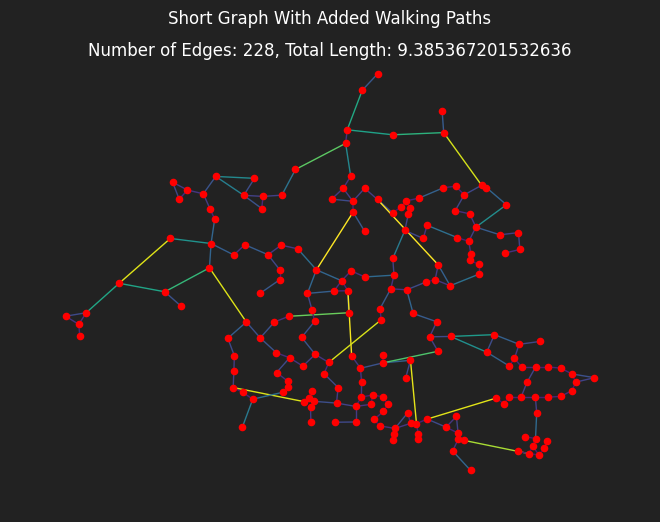

In [124]:
walking_graph = nx.Graph()
for node in short_graph.nodes():
    walking_graph.add_node(node, attr_dict=short_graph.nodes[node]['attr_dict'])
for edge in short_graph.edges():
    walking_graph.add_edge(edge[0], edge[1], weight=short_graph.edges[edge]['weight'])

'''process the nodes and if a node is within the average distance between points, but traverses a longer distance, add an edge between the two nodes'''
avg_dist = sum([d['weight'] for _, _, d in short_graph.edges(data=True)])/short_graph.number_of_edges()
# print(max([d['weight'] for _, _, d in short_graph.edges(data=True)]))
# get the weight of the edge between 2 nodes from edge_list

edges_in_radius = []
for edge in edgelist.iterrows():
    #was 4
    if (edge[1]["distance"] < avg_dist*4):#&(edge[1]["distance"] > avg_dist*2):
        edges_in_radius.append(edge)

#print(len(edges_in_radius))

for node in walking_graph.nodes():
    for edge in edges_in_radius:
        if edge[1]["node1"] == node:
            #was 400
            if nx.shortest_path_length(walking_graph, edge[1]["node1"], edge[1]["node2"]) > (avg_dist*350):
                walking_graph.add_edge(edge[1]["node1"], edge[1]["node2"], weight=edge[1]["distance"])

walking_graph_total_length = sum([d['weight'] for _, _, d in walking_graph.edges(data=True)])
plt.figure(figsize=(8,6))
edge_colors = [walking_graph[u][v]['weight'] for u,v in walking_graph.edges()]
fig = plt.figure()
nx.draw(walking_graph, pos = node_positions, node_size=20, edge_color = edge_colors, node_color='r')
fig.set_facecolor("#222222")
plt.title("Short Graph With Added Walking Paths", color='white')
plt.suptitle(f"Number of Edges: {walking_graph.number_of_edges()}, Total Length: {walking_graph_total_length}", color='white')
plt.show()



Export the map to gml and kml

In [112]:
nx.write_gml(walking_graph, "walking.gml", repr)
with open("walking.gml", 'r', encoding='utf-8') as file:
    data = file.readlines()
walking_nodes = []
walking_edges = []
for i, line in enumerate(data):
    if data[i] == '  node [\n':
        id = int(data[i+1].strip().split(' ')[1])
        label = data[i+2].strip()[8:-2]
        long = float(data[i+4].strip().split(' ')[1])
        lat = float(data[i+5].strip().split(' ')[1])
        walking_nodes.append((label, long, lat))

    if data[i] == '  edge [\n':
        source = walking_nodes[int(data[i+1].strip().split(' ')[1])]
        target = walking_nodes[int(data[i+2].strip().split(' ')[1])]
        walking_edges.append((source, target))

In [113]:
with open("walking.kml", 'w', encoding='utf-8') as file:
    file.write('''<?xml version=\"1.0\" encoding=\"UTF-8\"?>
    <kml xmlns=\"http://www.opengis.net/kml/2.2\">
    <Document>''')
    file.write('''
        <Style id=\"icon-blue-dot\">
            <LabelStyle>
                <scale>.6</scale>
                <color>ff00ffff</color>
            </LabelStyle>
            <IconStyle>
                <scale>.3</scale>
                <Icon>
                    <href>https://icones.pro/wp-content/uploads/2021/04/icone-cercle-rempli-bleu.png</href>
                </Icon>
            </IconStyle>
        </Style>
        ''')
    for node in walking_nodes:
        file.write(f'''
        <Placemark>
            <name>{node[0]}</name>
            <styleUrl>#icon-blue-dot</styleUrl>
            <Point>
                <coordinates>
                    {node[1]},{node[2]},0
                </coordinates>
            </Point>
        </Placemark>
    ''')
    for edge in walking_edges:
        file.write(f'''
        <Placemark>
            <Style>
                <LineStyle>
                    <color>#ff0000ff</color>
                    <width>4</width>
                </LineStyle>
            </Style>
            <LineString>
                <coordinates>
                    {edge[0][1]},{edge[0][2]},0
                    {edge[1][1]},{edge[1][2]},0
                </coordinates>
            </LineString>
        </Placemark>
        ''')
    file.write("</Document>\n</kml>")